Reference: 

- https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation

- https://github.com/tkshnkmr/frcnn_medium_sample

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image

from pycocotools.coco import COCO

import torch
from torch import nn
import torch.ao.quantization as tq
import torch.utils.data
import torchvision as tv
import torchvision.transforms as T
import onnxruntime

from ubervvald.DNAS import prepare_NAS, NASConfig, NAS_train
from ubervvald.quant import prepare_quantize, quantize


from MobileNetV2 import MobileNetV2

import warnings
warnings.filterwarnings('ignore')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [2]:
dataDir='coco2017'
dataType='val2017'
annFile='{}/sama_val.json'.format(dataDir,dataType)
imageDir = '{}/{}/'.format(dataDir, dataType)
CH_NR = 1
# Initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [3]:
# Load categories for the given ids
ids = 1
cats = coco.loadCats(ids=ids)
print(cats)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}]


In [4]:
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
ptId = 0
ptDict = dict()
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    # print(cats[0])
    ptDict[cats[0]['id']] = ptId
    ptId += 1

number of categories:  80


In [5]:
# Load images for the given ids
image_ids = coco.getImgIds() # you can also download them via coco.download(dict["flick_url"])
image_id = image_ids  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
# for info in image_info:
    # print(info)# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
for ann in annotations[:20]:
    print(ann)# Load annotations for the given ids
# print(annotations)

{'segmentation': [[302, 426, 326, 396, 333, 396, 337, 393, 336, 273, 346, 264, 346, 256, 345, 251, 339, 247, 226, 237, 211, 238, 203, 241, 0, 327, 1, 427]], 'area': 53095.5, 'iscrowd': 0, 'image_id': 397133, 'bbox': [0, 237, 346, 190], 'category_id': 67, 'id': 912349}
{'segmentation': [[447, 71, 456, 70, 466, 73, 471, 79, 474, 89, 474, 98, 473, 104, 462, 112, 466, 118, 476, 126, 485, 136, 494, 158, 497, 174, 498, 182, 485, 190, 474, 189, 471, 202, 473, 292, 475, 300, 474, 311, 475, 327, 474, 334, 469, 344, 459, 344, 456, 339, 455, 333, 450, 324, 444, 269, 433, 250, 419, 305, 407, 340, 404, 343, 398, 345, 394, 343, 392, 339, 388, 335, 385, 330, 386, 324, 389, 324, 408, 182, 399, 182, 394, 176, 393, 171, 389, 167, 391, 147, 418, 119, 434, 112, 430, 99, 427, 90, 429, 81, 438, 71, 444, 70]], 'area': 17527.5, 'iscrowd': 0, 'image_id': 397133, 'bbox': [385, 70, 113, 275], 'category_id': 1, 'id': 912350}
{'segmentation': [[136, 253, 154, 277, 158, 278, 152, 270, 142, 253, 139, 250, 137, 249, 

In [6]:
# Load images for the given ids
image_ids = coco.getImgIds() # you can also download them via coco.download(dict["flick_url"])
image_id = image_ids[0]  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
print(image_info)

[{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}]


In [7]:
# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
print(annotations)

[{'segmentation': [[302, 426, 326, 396, 333, 396, 337, 393, 336, 273, 346, 264, 346, 256, 345, 251, 339, 247, 226, 237, 211, 238, 203, 241, 0, 327, 1, 427]], 'area': 53095.5, 'iscrowd': 0, 'image_id': 397133, 'bbox': [0, 237, 346, 190], 'category_id': 67, 'id': 912349}, {'segmentation': [[447, 71, 456, 70, 466, 73, 471, 79, 474, 89, 474, 98, 473, 104, 462, 112, 466, 118, 476, 126, 485, 136, 494, 158, 497, 174, 498, 182, 485, 190, 474, 189, 471, 202, 473, 292, 475, 300, 474, 311, 475, 327, 474, 334, 469, 344, 459, 344, 456, 339, 455, 333, 450, 324, 444, 269, 433, 250, 419, 305, 407, 340, 404, 343, 398, 345, 394, 343, 392, 339, 388, 335, 385, 330, 386, 324, 389, 324, 408, 182, 399, 182, 394, 176, 393, 171, 389, 167, 391, 147, 418, 119, 434, 112, 430, 99, 427, 90, 429, 81, 438, 71, 444, 70]], 'area': 17527.5, 'iscrowd': 0, 'image_id': 397133, 'bbox': [385, 70, 113, 275], 'category_id': 1, 'id': 912350}, {'segmentation': [[136, 253, 154, 277, 158, 278, 152, 270, 142, 253, 139, 250, 137, 24

In [8]:
# Get category ids that satisfy the given filter conditions
filterClasses = ['laptop', 'tv', 'cell phone']
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

# Load category information for the given ID
catID = 15
print(coco.loadCats(ids=catID))

# Get image ID that satisfies the given filter conditions
imgId = coco.getImgIds(catIds=[catID])
print(imgId)
imgId = imgId[0]
ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(ann_ids)

[72, 73, 77]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[349184, 173057, 241668, 214539, 306700, 546829, 84492, 133645, 458768, 266768, 377368, 48153, 514586, 58393, 434204, 17436, 137246, 534041, 476704, 395801, 332318, 261161, 320554, 549930, 347693, 328238, 379441, 420916, 433204, 254516, 559160, 181816, 227898, 18491, 462904, 289343, 537153, 134722, 179265, 78404, 438862, 301135, 419408, 277584, 186449, 372819, 231508, 70229, 506454, 527960, 116825, 232538, 364636, 25181, 89697, 271457, 120420, 511076, 87144, 279145, 326248, 259690, 67180, 30828, 70254, 409198, 210032, 150638, 129135, 342128, 94326, 287874, 333956, 289417, 182923, 388258, 206994, 49810, 227478, 112378, 577182, 121506, 227491, 349860, 566436, 267940, 323751, 527528, 335529, 563882, 168619, 446117, 314541, 61108, 439994, 132796, 515266, 97988, 553669, 87244, 391375, 78032, 340175, 327890, 29397, 542423, 486104, 413404, 291551, 203488, 295138, 13546, 539883, 273132, 197870, 300276, 11511, 428280, 222458

Annotations for Image ID 349184:
000000349184.jpg


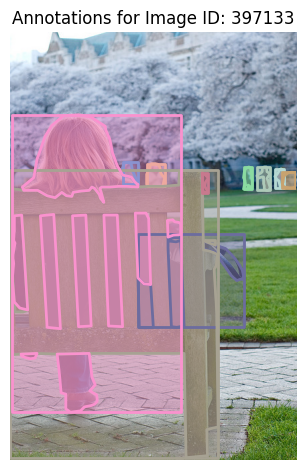

In [9]:
print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(image_id))
plt.tight_layout()
plt.show()

In [10]:
class cocoPTDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.in_channel = CH_NR
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.catIds = self.coco.getCatIds()
        self.catFrq = torch.Tensor([len(self.coco.getImgIds(catIds=cat)) for cat in self.catIds])
        # derive corresponding loss weights as w_class_i = tot_windows / class_i_windows
        self.catWeights = torch.sum(self.catFrq, dim=0) / (self.catFrq)

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        
        # Labels (In my case, I only one class: target class or background)
        catIds = [ann["category_id"] for ann in coco_annotation]
        labels = torch.Tensor([1 if pos in catIds else 0 for pos in range(len(classes))])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, labels#my_annotation

    def __len__(self):
        return len(self.ids)

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images 
                      
transform= T.Compose([T.Grayscale(CH_NR),
                    #   T.RandomCrop(128),
                      T.Resize((512, 512)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                    #   T.Normalize(*imagenet_stats)
                      ])

# collate_fn needs for batch
# def collate_fn(batch):
#     return tuple(zip(*batch))


In [11]:
classes = open("coco.names", "r").read().splitlines()
print(classes)

train_ds = cocoPTDataset("coco2017/train2017/", "coco2017/sama_train.json", transforms = transform)
val_ds = cocoPTDataset("coco2017/val2017/", "coco2017/sama_val.json", transforms = transform)
test_ds = cocoPTDataset("coco2017/train2017/", "coco2017/sama_test.json", transforms = transform)
len(train_ds), len(test_ds), len(val_ds)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
loading annotations into memory...
Done (t=8.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
c

(114336, 35665, 5000)

In [13]:
def denorm(img_tensors): #this function will denormalize the tensors 
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", label)
  print()
  print(label)
# show_example(*train_ds[11380]) #let's take an example

In [14]:

model = MobileNetV2(n_classes=len(classes), input_channel=CH_NR, quantize=True)
print(model)

@NASConfig
def crit(train_ds):
    if "dataset" in dir(train_ds):
        train_ds = train_ds.dataset
        
    w = train_ds.catWeights.detach().clone()
    # create an instance of the torch.nn.CrossEntropyLoss with weight and label_smoothing and return it 
    crit = torch.nn.BCELoss(weight=w.to(NASConfig.get_device()))
    return crit

#@NASConfig
# def optimizer(model):
#     # Set up custom optimizer with weight decay
#     optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
#     # Set up one-cycle learning rate scheduler
#     # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
#     return optim

#@NASConfig
# def nas_opt(model):
#     net_optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
#     nas_optim = opt_func(model.parameters(), lr=NASConfig.get_nas_lr())
#     return net_optim, nas_optim


TRAINING_CONFIG = {
    'model_dir': pathlib.Path("experiments/mobilenet/nas_model/"),
    'epochs': 150,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'nas_learning_rate': 0.0005,
    'label_smoothing': 0.25,
    'weight_decay':1e-4,
    'patience': 10,
    'reg_strengths': [1e-8, 0],
    'criterion': crit,
    "last_layer_activation": torch.nn.functional.sigmoid,
    # 'optimizer': optimizer,
    'num_classes': len(classes),
    # 'qat_qconfig': tq.get_default_qat_qconfig(backend='x86', version=1),
    # 'nas_optimizer':nas_opt,
    'isMultilabel' : True,
    'isGPU': True,
}

MobileNetV2(
  (model): Sequential(
    (0): QuantStub()
    (1): ConvNormReLUBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): InverseResidualBlock(
      (conv1): Identity()
      (depthwise_conv): ConvNormReLUBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (conv2): ConvNormReLUBlock(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): Identity()
      )
    )
    (3): InverseResidualBlock(
      (conv1): ConvNormReLUBlock(
        (conv): Conv2d(16, 96, kernel_size=(1

In [51]:
prepare_NAS(TRAINING_CONFIG)
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model = NAS_train(model, train_ds, val_ds, test_ds)

Training data-loader length: 3573 (nr. of batches)
Validation data-loader length: 157 (nr. of batches)
Test data-loader length: 1115 (nr. of batches)
Working on: cuda:0
Val Seed Macro Acc: 0.5158324837684631
Model's initial cost (nr. of param): 2,291,664.0
Training with strength 1e-08
Skipping NAS and loading pre-cooked model from: experiments/mobilenet/nas_model/pit_nas_1e-08
Test Loss: 13.22, Test Acc: 0.22, Test Macro Acc: 0.98

Working on: cuda:0
Selected regularization strength: 1e-08
Test Macro Acc after re-loading: 0.9810356497764587
Model's cost (nr. of param) after NAS: 1,047,722.0
Skipping training and loading pre-cooked model from: experiments/mobilenet/nas_model/pit_finetune_1e-08
Final Optimized Model Test Loss: 9.46, Test Acc: 0.17, Test Macro Acc: 0.98


In [15]:
model = torch.load("experiments/mobilenet/nas_model/final_model_1e-08.pt")
config = {
    'arch': 'mobilenetv2',
    'quant_format': onnxruntime.quantization.QuantFormat.QOperator,
    'quant_w_type': onnxruntime.quantization.QuantType.QInt8,
    'quant_a_type': onnxruntime.quantization.QuantType.QUInt8,
    'batch_size': 1,
    'model_dir': 'experiments/mobilenetv2/quant_models/',
    'last_layer_activation': torch.nn.functional.sigmoid,
    'isGPU': False,
}
prepare_quantize(model, config)
quantize(test_ds)

Evaluating ONNX vs TorchScript


100%|##########| 500/500 [00:35<00:00, 14.27batches/s]


Fscore ref:  tensor(0.9799)
Fscore sample:  tensor(0.9799)


Evaluating ONNX vs qONNX


100%|##########| 500/500 [00:30<00:00, 16.50batches/s]


Fscore ref:  tensor(0.9797)
Fscore sample:  tensor(0.9796)




In [ ]:
import onnx
from onnx import numpy_helper

model_path = "experiments/mobilenetv2/quant_models/mobilenetv2_int8.onnx"

def count_parameters(onnx_model_path):
    model = onnx.load(onnx_model_path)
    total_parameters = 0
    for initializer in model.graph.initializer:
        total_parameters += numpy_helper.to_array(initializer).size
    return total_parameters

num_params = count_parameters(model_path)
print("num_of_params: ", num_params)        